In [1]:
import sys
sys.path.append('../../')

import torch as tc
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from rcgp.experimental import SpatioTemporalRCGP
from matplotlib.colors import LinearSegmentedColormap

from data.simulations import spatio_temporal_half_contaminated

plt.rc('font', family='serif', size=14)

In [2]:
ts, grids, Ys, true_Ys, Ys_no_outliers, outliers_loc, n_lon, n_lat, lon_norm, lat_norm = spatio_temporal_half_contaminated()

In [5]:
ts.shape

torch.Size([10, 1])

In [4]:
strcgp = SpatioTemporalRCGP(ts=ts, Ys=Ys, grid=grids[0], p=1)
strcgp.activate_robustness(func='m_pred')
strcgp.beta = 0.6
strcgp.c = 4.
strcgp.temporal_lengthscale = 0.4
strcgp.spatial_lengthscale = 0.8
strcgp.var_y = 1

with tc.no_grad():
    (preds_IMQ_smooth, stds_IMQ_smooth, eff_IMQ), _, _ = strcgp.forward()

    strcgp.deactivate_robustness()
    (preds_std_smooth, stds_std_smooth, eff_std), _, _ = strcgp.forward()


In [5]:
def plot(t, R, Y, pred1, pred2, pred1_title, pred2_title, title="Spatio-Temporal GP"):

    time_idx_to_plot = [5, 7, 9]
    n_time_steps = len(time_idx_to_plot)

    fig, axs = plt.subplots(4, n_time_steps, figsize=(6,4), sharex=True, sharey=True)
    times = []
    left_noise_abs_diff = []
    left_pred1_abs_diff = []
    left_pred2_abs_diff = []

    right_noise_abs_diff = []
    right_pred1_abs_diff = []
    right_pred2_abs_diff = []

    colors = [
    (12/255, 44/255, 132/255),  # Deep Ocean Blue
    (30/255, 94/255, 172/255),  # Rich Blue
    (72/255, 150/255, 205/255),  # Sky Blue
    (144/255, 205/255, 220/255),  # Soft Cyan
    (234/255, 242/255, 227/255),  # Pale Mint
    (250/255, 210/255, 130/255),  # Light Gold
    (250/255, 190/255, 85/255),   # Soft Golden Orange
    ]

    cmap = LinearSegmentedColormap.from_list("MLPaperColormap", colors, N=1024)

    for idx, time_idx in enumerate(time_idx_to_plot):

        Y_arr = Y[time_idx].reshape(n_lon, n_lat).T
        Ys_no_outliers_arr = Ys_no_outliers[time_idx].reshape(n_lon, n_lat).T
        pred1_arr = pred1[time_idx].reshape(n_lon, n_lat).T
        pred2_arr = pred2[time_idx].reshape(n_lon, n_lat).T
        Ys_true = true_Ys[time_idx].reshape(n_lon, n_lat).T
        t_val = float(t[time_idx][0])

        vmin = Ys_no_outliers_arr.min()
        vmax = Ys_no_outliers_arr.max()

        times.append(t_val)

        x_split_idx = np.argmin(lon_norm < 0)

        left_noise_abs_diff.append(np.sqrt(((Y_arr[:, :x_split_idx] - Ys_true[:, :x_split_idx])**2).sum()))
        left_pred1_abs_diff.append(np.sqrt(((pred1_arr[:, :x_split_idx] - Ys_true[:, :x_split_idx])**2).sum()))
        left_pred2_abs_diff.append(np.sqrt(((pred2_arr[:, :x_split_idx] - Ys_true[:, :x_split_idx])**2).sum()))


        right_noise_abs_diff.append(np.sqrt(((Y_arr[:, x_split_idx:] - Ys_true[:, x_split_idx:])**2).sum()))
        right_pred1_abs_diff.append(np.sqrt(((pred1_arr [:, x_split_idx:] - Ys_true[:, x_split_idx:])**2).sum()))
        right_pred2_abs_diff.append(np.sqrt(((pred2_arr[:, x_split_idx:] - Ys_true[:, x_split_idx:])**2).sum()))
  

        R_arr = R[time_idx]
        X_lon = R_arr[:, 0].reshape(n_lon, n_lat).T
        X_lat = R_arr[:, 1].reshape(n_lon, n_lat).T
    
        im = axs[0, idx].contourf(X_lon, X_lat, Ys_no_outliers_arr, cmap=cmap)
        outliers_loc_t = outliers_loc[np.where(np.isclose(outliers_loc[:, 0], t_val))]
        axs[0, idx].scatter(outliers_loc_t[:, 1], outliers_loc_t[:, 2], marker='.', s=5., color='red')

        axs[1, idx].contourf(X_lon, X_lat, pred1_arr, vmin=vmin, vmax=vmax, cmap=cmap)

        axs[2, idx].contourf(X_lon, X_lat, pred2_arr, vmin=vmin, vmax=vmax, cmap=cmap)

        axs[3, idx].contourf(X_lon, X_lat, Ys_true, vmin=vmin, vmax=vmax, cmap=cmap)


        axs[0, idx].set_title("t={:.2f}".format(float(t[time_idx][0])))

        axs[0,0].set_ylabel("Data")
        axs[1,0].set_ylabel(pred1_title)
        axs[2,0].set_ylabel(pred2_title)
        axs[3,0].set_ylabel("Truth")
    
    #fig.colorbar(im, ax=axs)
    cbar = fig.colorbar(im, ax=axs, orientation="vertical", fraction=0.046, pad=0.04)

    #cax, kw = mpl.colorbar.make_axes([ax for ax in axs.flat])
    #plt.colorbar(im, cax=cax, **kw)
    
    #fig.suptitle(title)

    df = pd.DataFrame(np.vstack([times, left_noise_abs_diff, left_pred1_abs_diff, left_pred2_abs_diff, right_noise_abs_diff, right_pred1_abs_diff, right_pred2_abs_diff]))
    df.index = ["times", "RMSE (Data, left)", pred1_title + " RMSE (left)", pred2_title + " RMSE (left)", "RMSE (Data, right)", pred1_title + " RMSE (right)", pred2_title + " RMSE (right)"]
    return df

,times,"RMSE (Data, left)",STGP RMSE (left),ST-RCGP RMSE (left),"RMSE (Data, right)",STGP RMSE (right),ST-RCGP RMSE (right)
0,0.533333,35.671523,5.631614,2.288872,13.414822,2.557374,2.209866
1,0.666667,39.513909,6.046292,1.925646,9.135121,2.481202,2.064759
2,0.800000,31.249494,6.144443,2.073680,7.066812,2.565626,1.371371


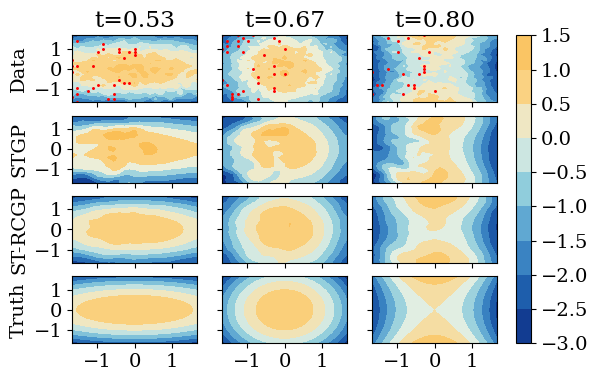

In [6]:
df = plot(ts, grids, Ys, pred1=preds_std_smooth, pred2=preds_IMQ_smooth, pred1_title="STGP", pred2_title="ST-RCGP", title="Spatio-Temporal GP - Simulation")
df.T
#plt.savefig("./simulated-spatio-temporal.pdf", format='pdf', bbox_inches='tight')